# Dataset Selection



 MicroscopyDataset: ImageFolderDataset[940]
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone10_composite_Mcropped_1.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone10_composite_Mcropped_2.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone11_composite_Mcropped_1.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone11_composite_Mcropped_2.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone11_composite_Mcropped_3.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone12_composite_Mcropped_1.tiff	label: 4
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone12_composite_Mcropped_2.tiff	label: 7
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone13_composite_Mcropped_1.tiff	label: 6
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone13_composite_Mcropped_2.tiff	label: 4
image: data/microscopy/images/raw_scale100/Ma190c_lame1_zone14_composite

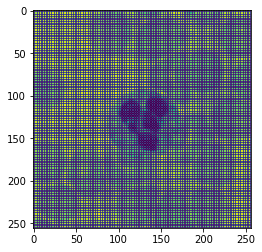

label: 7
class: NGS


 DroneDatasetClassificationTiled: ImageFolderDataset[930]
image: data/drone/classification/images_tiles_256_thr_0.01/00_00000.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00001.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00002.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00003.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00004.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00005.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00006.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00007.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00008.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00009.tif	label: 1
image: data/drone/classification/images_tiles_256_thr_0.01/00_00010.tif	label: 1
image: data/drone/classificat

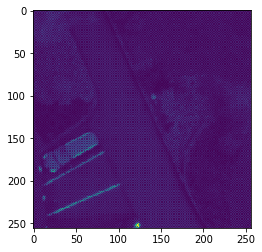

label: 1
class: no car


 DroneDatasetSegmentationTiled: ImageFolderDatasetSegmentation[548]
image: data/drone/images_tiles_256/00_00000.tif	mask: data/drone/masks_tiles_256/00_00000.png
image: data/drone/images_tiles_256/00_00001.tif	mask: data/drone/masks_tiles_256/00_00001.png
image: data/drone/images_tiles_256/00_00002.tif	mask: data/drone/masks_tiles_256/00_00002.png
image: data/drone/images_tiles_256/00_00003.tif	mask: data/drone/masks_tiles_256/00_00003.png
image: data/drone/images_tiles_256/00_00004.tif	mask: data/drone/masks_tiles_256/00_00004.png
image: data/drone/images_tiles_256/00_00005.tif	mask: data/drone/masks_tiles_256/00_00005.png
image: data/drone/images_tiles_256/00_00006.tif	mask: data/drone/masks_tiles_256/00_00006.png
image: data/drone/images_tiles_256/00_00007.tif	mask: data/drone/masks_tiles_256/00_00007.png
image: data/drone/images_tiles_256/00_00008.tif	mask: data/drone/masks_tiles_256/00_00008.png
image: data/drone/images_tiles_256/00_00009.tif	mask: data/dr

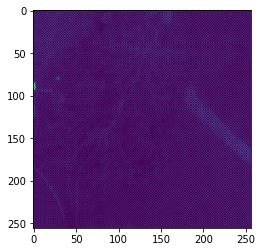


mask file: data/drone/masks_tiles_256/00_00003.png
mask shape: (256, 256)
mask (min, max): (0.0, 1.0)


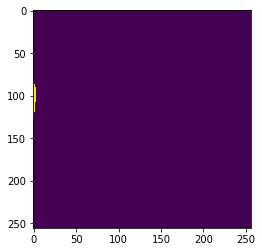

In [3]:
%matplotlib inline
from dataset import get_dataset
import matplotlib.pyplot as plt

N = 3

for dataset_name in ['Microscopy', 'Drone', 'DroneSegmentation']:
    dataset = get_dataset(dataset_name)
    print('\n\n', dataset)
    print(f'task: {dataset.task}')
    if dataset.task == 'classification':
        for label, _class in enumerate(dataset.classes):
            count = dataset.labels.count(label)
            print(f'\t{_class}: {dataset.labels.count(label):4d} \t{count / len(dataset.labels) * 100:.1f}%')
    img, label = dataset[N]
    print(f'\nshowing index: {N}')
    print(f'image file: {dataset.images[N]}')
    print(f'image shape: {img.shape}')
    print(f'image (min, max): ({img.min():.3f}, {img.max():.3f})')
    plt.imshow(img)
    plt.show()
    if dataset.task == 'segmentation':
        mask = label
        print(f'\nmask file: {dataset.masks[N]}')
        print(f'mask shape: {mask.shape}')
        print(f'mask (min, max): ({mask.min()}, {mask.max()})')
        plt.imshow(mask)
        plt.show()
    else:
        print(f'label: {label}')
        print(f'class: {dataset.classes[label]}')


# Processing

pipeline norm difference: 6.971022129058838


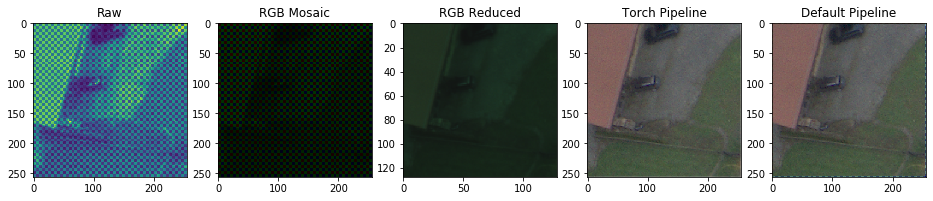

pipeline norm difference: 0.567720353603363


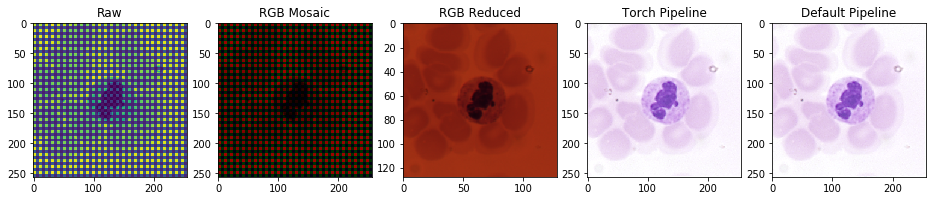

In [25]:
import sys
sys.path.append('..')

import torch
import numpy as np

import matplotlib.pyplot as plt
from utils.dataset import get_dataset
from utils.base import np2torch, torch2np

from processingpipeline.pipeline import processing as default_processing
from processingpipeline.torch_pipeline import raw2rgb, ParametrizedProcessing

for dataset_name in ['DS', 'M']:
    dataset = get_dataset(dataset_name)
    loader = torch.utils.data.DataLoader(dataset, batch_size=1)
    batch_raw, batch_mask = next(iter(loader))

    # torch proc
    camera_parameters = dataset.camera_parameters
    black_level = camera_parameters[0]

    proc = ParametrizedProcessing(camera_parameters)

    batch_rgb = proc(batch_raw)
    rgb = batch_rgb[0]

    # numpy proc
    raw_img = batch_raw[0]
    numpy_raw = torch2np(raw_img)

    default_rgb = default_processing(numpy_raw, *camera_parameters,
                                        sharpening='sharpening_filter', denoising='gaussian_denoising')

    rgb_valid = np2torch(default_rgb)

    print("pipeline norm difference:", (rgb - rgb_valid).norm().item())

    rgb_mosaic = raw2rgb(batch_raw, reduce_size=False).squeeze()
    rgb_reduced = raw2rgb(batch_raw, reduce_size=True).squeeze()

    plt.figure(figsize=(16, 12))
    plt.subplot(151)
    plt.title('Raw')
    plt.imshow(torch2np(raw_img))
    plt.subplot(152)
    plt.title('RGB Mosaic')
    plt.imshow(torch2np(rgb_mosaic))
    plt.subplot(153)
    plt.title('RGB Reduced')
    plt.imshow(torch2np(rgb_reduced))
    plt.subplot(154)
    plt.title('Torch Pipeline')
    plt.imshow(torch2np(rgb))
    plt.subplot(155)
    plt.title('Default Pipeline')
    plt.imshow(torch2np(rgb_valid))
    plt.show()

# Augmentation

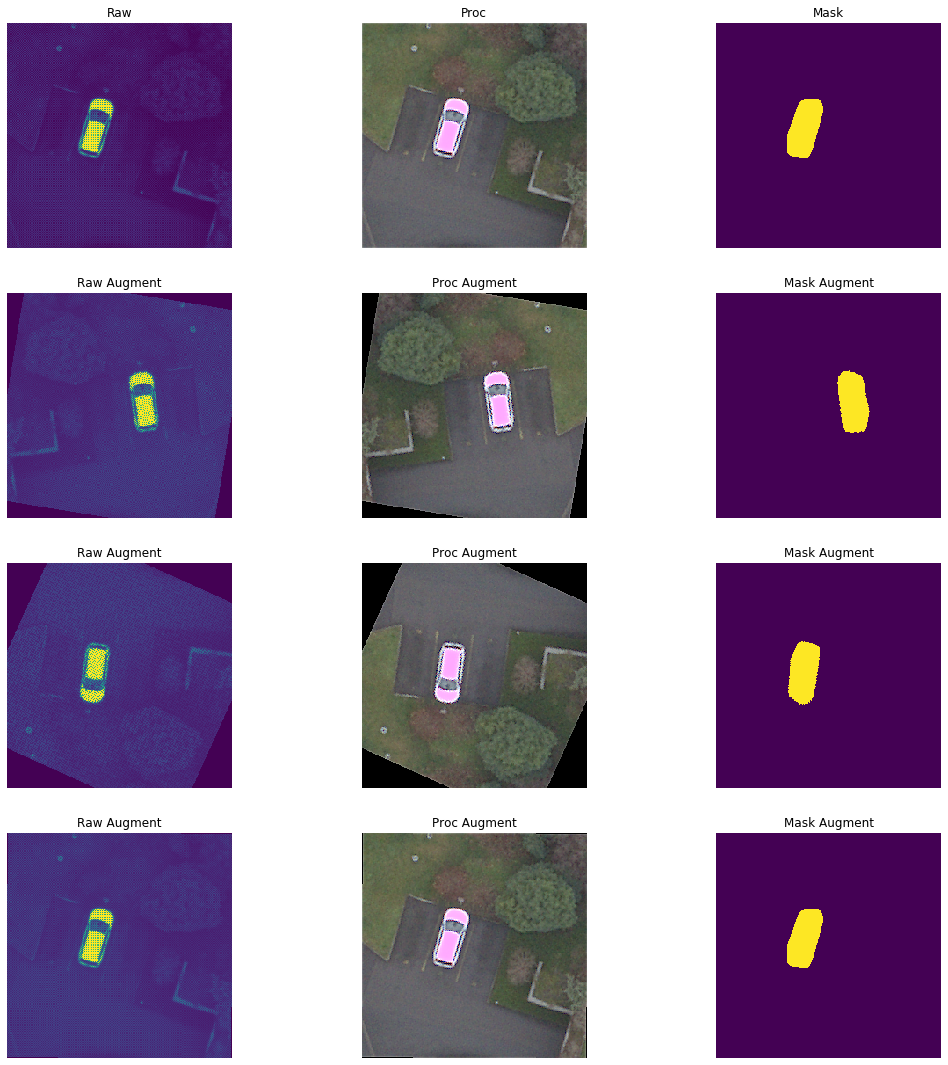

In [21]:

import matplotlib.pyplot as plt
from dataset import get_dataset
from augmentation import get_augmentation, set_global_seed
from processingpipeline.torch_pipeline import ParametrizedProcessing
from base import np2torch, torch2np

dataset = get_dataset('DS')  # drone segmentation
raw, mask = dataset[10]

# torch proc
camera_parameters = dataset.camera_parameters
proc = ParametrizedProcessing(camera_parameters)


plt.figure(figsize=(18, 24))
plt.tight_layout()

plt.subplot(531)
plt.title('Raw')
plt.axis('off')
plt.imshow(raw)
plt.subplot(532)
plt.title('Proc')
plt.axis('off')
plt.imshow(torch2np(proc(np2torch(raw).unsqueeze(0)).squeeze()))
plt.subplot(533)
plt.title('Mask')
plt.axis('off')
plt.imshow(mask)

# from utils.augmentation import get_augmentation
augmentation = get_augmentation('strong')

set_global_seed(1)

raw, mask = np2torch(raw), np2torch(mask)

for i in range(1, 4):
    raw_aug = torch2np(augmentation(raw.unsqueeze(0), retain_state=True)).squeeze()
    proc_aug = torch2np(augmentation(proc(raw.unsqueeze(0)), retain_state=True)).squeeze()
    mask_aug = torch2np(augmentation(mask.unsqueeze(0), mask_transform=True)).squeeze()
    plt.subplot(5,3,1 + i*3)
    plt.title('Raw Augment')
    plt.axis('off')
    plt.imshow(raw_aug)
    plt.subplot(5,3,2 + i*3)
    plt.title('Proc Augment')
    plt.axis('off')
    plt.imshow(proc_aug)
    plt.subplot(5,3,3 + i*3)
    plt.imshow(mask_aug)
    plt.title('Mask Augment')
    plt.axis('off')
plt.show()